# Impact of outliers (1D regression example)

Here we provide a simple example showing how different risks lead to different behaviour on a regression task involving outliers.

- Basic setup
- Visualize the data and loss distributions
- Loss trajectories and regression lines
  - Initial comparison across risk classes

## Basic setup

In [1]:
## External modules.
from copy import deepcopy
from matplotlib import cm
from matplotlib.colors import BoundaryNorm
from matplotlib.pyplot import savefig, show, subplots, tight_layout
import numpy as np
from os import path
from scipy.stats import linregress

## Internal modules.
from mml.algos.gd import GD_ERM
from mml.losses.absolute import Absolute
from mml.losses.cvar import CVaR
from mml.losses.dro import DRO_CR
from mml.losses.quadratic import Quadratic
from mml.losses.tilted import Tilted
from mml.models.linreg import LinearRegression
from mml.utils import makedir_safe
from mml.utils.mest import est_loc_fixedpt
from setup_algos import GD_ERM_Tilted, GD_ERM_DRO_CR, GD_ERM_CustomThreshold
from setup_data import get_data
from setup_dispersions import get_dispersion
from setup_losses import R_Risk, T_Risk, T_Risk_General, T_Risk_CustomThreshold, ConvexPolynomial
from setup_results import img_dir, results_dir, my_fontsize, my_ext, export_legend

In [2]:
## Create directory to save figures.
makedir_safe(img_dir)

In [3]:
## Prep of typical "base loss" functions.
loss_abs = Absolute()
loss_quad = Quadratic()
base_loss_dict = {"quadratic": loss_quad, "absolute": loss_abs}
huber_threshold = 0.25

In [4]:
## Prep of dataset-related clerical details.
dataset_dict = {
    "phones": {"xlabel": "Year",
               "ylabel": "Phone calls",
               "do_normalize": True,
               "do_shuffle": False,
               "feature_idx": None},
    "phonesHighLev": {"xlabel": "Year",
                      "ylabel": "Phone calls (modified)",
                      "do_normalize": True,
                      "do_shuffle": False,
                      "feature_idx": None}
}

In [5]:
## Choose and load a dataset.
dataset = "phones" # from ["phones", "phonesHighLev"]
dataset_kwargs = dataset_dict[dataset]

rg = np.random.default_rng()
(X_train, y_train, X_val, y_val,
 X_test, y_test, ds_paras) = get_data(dataset="phones", rg=rg,
                                      do_normalize=dataset_kwargs["do_normalize"],
                                      do_shuffle=dataset_kwargs["do_shuffle"])
X = (np.vstack([X_train, X_val, X_test]))
if dataset_kwargs["feature_idx"] is not None:
    X = X[:,dataset_kwargs["feature_idx"]].reshape(len(X),1)
X_padded = np.hstack([X, np.ones(X.shape, dtype=X.dtype)])
y = np.vstack([y_train, y_val, y_test])
#y = (y - y.min()) / (y.max() - y.min()) # normalizing the outputs.
if dataset == "phonesHighLev":
    X[-6] *= 5 # make a high-leverage point.
    y[-6] *= 5 # make the high-leverage point also an outlier.

/home/mjh/Dropbox/research/code/dev/mml-dev/mml/data/phones/phones.h5 (File) 'phones: Full dataset'
Last modif.: '2021-11-18T01:41:32+00:00'
Object Tree: 
/ (RootGroup) 'phones: Full dataset'
/X (Array(24, 1)) 'phones: Features'
/y (Array(24, 1)) 'phones: Labels'

Type: X (<class 'numpy.ndarray'>)
Type: y (<class 'numpy.ndarray'>)
--Shapes--
n_all: 24 num_features: 1 num_labels: 1
--Subset sizes--
n_train: 19 n_val: 2 n_test: 3
Data types:
X_train: <class 'numpy.ndarray'> y_train: <class 'numpy.ndarray'>
X_val: <class 'numpy.ndarray'> y_val: <class 'numpy.ndarray'>
X_test: <class 'numpy.ndarray'> y_test: <class 'numpy.ndarray'>


In [6]:
## Two distinct initial points.
w_init_down = np.array([0.0,0.0])
w_init_up = np.array([0.0,np.max(y)])
w_inits = {"down": w_init_down, "up": w_init_up}

## Visualize the data and loss distributions

In [7]:
## Initialize models.
model_down = LinearRegression(num_features=X_padded.shape[1], rg=rg)
model_up = LinearRegression(num_features=X_padded.shape[1], rg=rg)
model_down.paras["w"] = w_init_down.reshape(model_down.paras["w"].shape)
model_up.paras["w"] = w_init_up.reshape(model_up.paras["w"].shape)

In [8]:
## Express the regression lines in a convenient format.
regline_down = (model_down.paras["w"][0].item(), model_down.paras["w"][1].item())
regline_up = (model_up.paras["w"][0].item(), model_up.paras["w"][1].item())
reglines_init = {"down": regline_down, "up": regline_up}

In [9]:
## Compute losses at the intial model.
losses_down = [loss_quad(model=model_down, X=X_padded, y=y),
               np.where(loss_abs(model=model_down, X=X_padded, y=y) <= huber_threshold,
                        loss_abs(model=model_down, X=X_padded, y=y)**2/2,
                        huber_threshold*(loss_abs(model=model_down, X=X_padded, y=y)-huber_threshold/2)),
               loss_abs(model=model_down, X=X_padded, y=y),
               loss_abs(model=model_down, X=X_padded, y=y)]
losses_up = [loss_quad(model=model_up, X=X_padded, y=y),
             np.where(loss_abs(model=model_up, X=X_padded, y=y) <= huber_threshold,
                      loss_abs(model=model_up, X=X_padded, y=y)**2/2,
                      huber_threshold*(loss_abs(model=model_up, X=X_padded, y=y)-huber_threshold/2)),
             loss_abs(model=model_up, X=X_padded, y=y)]

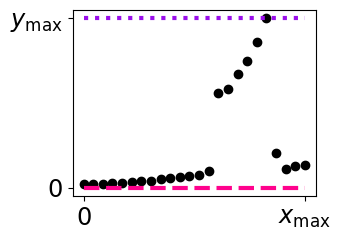

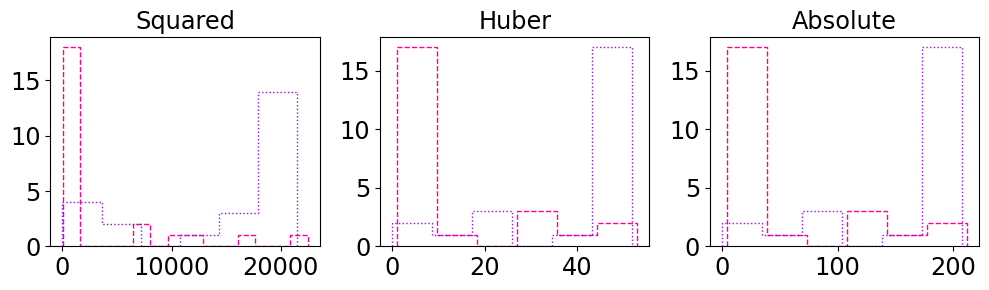

In [10]:
## First plot the data, and a pair of natural initial values.
fig, ax = subplots(1, 1, figsize=(3.5,2.5))
x_data = X.reshape(-1)
y_data = y.reshape(-1)
x_values = np.linspace(0, np.max(x_data), 100)
ax.scatter(x_data, y_data, color="xkcd:black")
ax.plot(x_values, x_values*regline_down[0] + regline_down[1], linewidth=3.0, color="xkcd:hot pink", ls="dashed")
ax.plot(x_values, x_values*regline_up[0] + regline_up[1], linewidth=3.0, color="xkcd:violet", ls="dotted")
ax.tick_params(labelsize=my_fontsize)
ax.set_xticks([0.0, np.max(x_data)])
ax.set_xticklabels(["0", r"$x_{\max}$"])
ax.set_yticks([0.0, np.max(y_data)])
ax.set_yticklabels(["0", r"$y_{\max}$"])
fname = path.join(img_dir, "outliers_{}_badinits.{}".format(dataset, my_ext))
tight_layout()
savefig(fname=fname)
show()

## Next, plot the relevant loss distributions.
fig, (ax1, ax2, ax3) = subplots(1, 3, figsize=(10,3), sharey=False)
ax1.hist(losses_down[0],
         bins="auto", color="xkcd:hot pink", ls="dashed", histtype="step",
         fill=False, hatch=None, orientation="vertical", density=False)
ax1.hist(losses_up[0],
         bins="auto", color="xkcd:violet", ls="dotted", histtype="step",
         fill=False, hatch=None, orientation="vertical", density=False)
ax1.set_title("Squared", size=my_fontsize)
ax1.tick_params(labelsize=my_fontsize)
ax2.hist(losses_down[1],
         bins="auto", color="xkcd:hot pink", ls="dashed", histtype="step",
         fill=False, hatch=None, orientation="vertical", density=False)
ax2.hist(losses_up[1],
         bins="auto", color="xkcd:violet", ls="dotted", histtype="step",
         fill=False, hatch=None, orientation="vertical", density=False)
ax2.set_title("Huber", size=my_fontsize)
ax2.tick_params(labelsize=my_fontsize)
ax3.hist(losses_down[2],
         bins="auto", color="xkcd:hot pink", ls="dashed", histtype="step",
         fill=False, hatch=None, orientation="vertical", density=False)
ax3.hist(losses_up[2],
         bins="auto", color="xkcd:violet", ls="dotted", histtype="step",
         fill=False, hatch=None, orientation="vertical", density=False)
ax3.set_title("Absolute", size=my_fontsize)
ax3.tick_params(labelsize=my_fontsize)
fname = path.join(img_dir, "outliers_{}_lossdists.{}".format(dataset, my_ext))
tight_layout()
savefig(fname=fname)
show()

## Loss trajectories and regression lines

In [11]:
## A few handy wrappers that grab model/loss/algo objects as desired.

def get_model(risk_name, rg, **kwargs):
    model = LinearRegression(num_features=kwargs["num_features"], rg=rg)
    model.paras["w"] = deepcopy(kwargs["w_init"]).reshape(model.paras["w"].shape)
    if risk_name == "rrisk":
        model.paras["theta"] = rg.uniform(low=0.0, high=0.05, size=(1,1))
    elif risk_name == "trisk":
        model.paras["theta"] = rg.uniform(low=0.0, high=0.05, size=(1,1))
    elif risk_name == "triskGeneral":
        pass # Nothing special to do in this case.
    elif risk_name == "triskCustom":
        pass # Nothing special to do in this case.
    elif risk_name == "cvar":
        model.paras["v"] = rg.uniform(low=0.0, high=0.05, size=(1,1))
    elif risk_name == "entropic":
        pass # Nothing special to do in this case.
    elif risk_name == "dro":
        model.paras["theta"] = rg.uniform(low=0.0, high=0.05, size=(1,1))
    else:
        raise ValueError("Please pass a proper risk class name.")
    return model


def get_loss(risk_name, loss_base, **kwargs):
    if risk_name == "rrisk":
        dispersion, dispersion_d1 = get_dispersion(name="barron", **kwargs)
        return R_Risk(loss_base=loss_base,
                      dispersion=dispersion,
                      dispersion_d1=dispersion_d1,
                      sigma=kwargs["sigma"], eta=kwargs["eta"])
    elif risk_name == "trisk":
        dispersion, dispersion_d1 = get_dispersion(name="barron", **kwargs)
        return T_Risk(loss_base=loss_base,
                      dispersion=dispersion,
                      dispersion_d1=dispersion_d1,
                      sigma=kwargs["sigma"], etatilde=kwargs["etatilde"])
    elif risk_name == "triskGeneral":
        dispersion, dispersion_d1 = get_dispersion(name="barron", **kwargs)
        return T_Risk_General(loss_base=loss_base,
                              dispersion=dispersion,
                              dispersion_d1=dispersion_d1,
                              theta=kwargs["theta_fixed"],
                              sigma=kwargs["sigma"],
                              etatilde=kwargs["etatilde"])
    elif risk_name == "triskCustom":
        dispersion, dispersion_d1 = get_dispersion(name="barron", **kwargs)
        set_threshold = lambda x: np.median(x)
        return T_Risk_CustomThreshold(loss_base=loss_base,
                                      dispersion=dispersion,
                                      dispersion_d1=dispersion_d1,
                                      set_threshold=set_threshold,
                                      sigma=kwargs["sigma"],
                                      etatilde=kwargs["etatilde"])
    elif risk_name == "cvar":
        return CVaR(loss_base=loss_base, alpha=1.0-kwargs["prob"])
    elif risk_name == "entropic":
        gamma = kwargs["gamma"]
        if gamma == 0.0:
            return loss_base
        else:
            return Tilted(loss_base=loss_base, tilt=gamma)
    elif risk_name == "dro":
        c = 2.0
        cstar = c / (c-1.0)
        a = ((1.0/(1.0-kwargs["atilde"]))-1.0)**2.0 / 2.0
        return DRO_CR(loss_base=loss_base, bound=a, shape=c)
    else:
        raise ValueError("Please pass a proper risk class name.")


def get_algo(risk_name, model, loss, **kwargs):
    if risk_name == "rrisk":
        return GD_ERM(step_coef=kwargs["step_size"], model=model, loss=loss)
    elif risk_name == "trisk":
        return GD_ERM(step_coef=kwargs["step_size"], model=model, loss=loss)
    elif risk_name == "triskGeneral":
        return GD_ERM(step_coef=kwargs["step_size"], model=model, loss=loss)
    elif risk_name == "triskCustom":
        return GD_ERM_CustomThreshold(step_coef=kwargs["step_size"], model=model, loss=loss)
    elif risk_name == "cvar":
        return GD_ERM(step_coef=kwargs["step_size"], model=model, loss=loss)
    elif risk_name == "entropic":
        gamma = kwargs["gamma"]
        if gamma == 0.0:
            return GD_ERM(step_coef=kwargs["step_size"], model=model, loss=loss)
        else:
            return GD_ERM_Tilted(tilt=gamma, step_coef=kwargs["step_size"],
                                 model=model, loss=loss)
    elif risk_name == "dro":
        c = 2.0
        cstar = c / (c-1.0)
        a = ((1.0/(1.0-kwargs["atilde"]))-1.0)**2.0 / 2.0
        return GD_ERM_DRO_CR(bound=a, shape=c, step_coef=kwargs["step_size"],
                             model=model, loss=loss)
    else:
        raise ValueError("Please pass a proper risk class name.")

### Initial comparison across risk classes

In [12]:
## Setup of risk hyperparameters.
todo_risks = ["triskGeneral", "cvar", "entropic", "dro"]
todo_riskparas = {
    "rrisk": ("alpha", np.linspace(-2.0, 2.0, 10)),
    "trisk": ("alpha", np.linspace(1.0, 2.0, 10)),
    "triskGeneral": ("alpha", np.linspace(-2.0, 1.0, 20)),
    "triskCustom": ("alpha", np.linspace(-2.0, 0.0, 10)),
    "cvar": ("prob", np.linspace(0.025, 0.90, 20)),
    "entropic": ("gamma", np.linspace(-0.025, 0.025, 20)),
    "dro": ("atilde", np.linspace(0.025, 0.8, 20))
}
aux_riskparas = {
    "rrisk": {"sigma": 0.1, "eta": 1.0},
    "trisk": {"sigma": 0.1, "etatilde": 0.99},
    "triskGeneral": {"sigma": 1.0, "etatilde": 0.99},
    "triskCustom": {"sigma": 0.1, "etatilde": 1.0},
    "cvar": {},
    "entropic": {},
    "dro": {}
}
risk_names = {"rrisk": "M-risk",
              "trisk": "T-risk",
              "triskGeneral": "T-risk",
              "triskCustom": "T-risk",
              "cvar": "CVaR risk",
              "entropic": "Tilted risk",
              "dro": r"$\chi^{2}$-DRO risk"}
para_names = {"alpha": r"$\alpha$",
              "prob": r"$\beta$",
              "gamma": r"$\gamma$",
              "atilde": r"$\widetilde{a}$"} 

In [13]:
## Experimental settings.
base_name = "quadratic"
loss_base = base_loss_dict[base_name]
step_size = 0.005
num_steps = 15000
init_name = "down"
model_kwargs = {"num_features": X_padded.shape[1],
                "w_init": w_inits[init_name]}
algo_kwargs = {"step_size": step_size}

In [14]:
## Storage preparation.
storage_base = {risk: {} for risk in todo_risks}
storage_obj = {risk: {} for risk in todo_risks}
storage_regline = {risk: {} for risk in todo_risks}

In [15]:
## Loop over the risk class.
for risk in todo_risks:
    
    print("Working on '{}' class...".format(risk))
    
    pname, riskparas = todo_riskparas[risk]
    aux_paras = aux_riskparas[risk]
    
    ## Loop over the individual risks.
    for riskpara in riskparas:
        
        ## Get the relevant model.
        model = get_model(risk_name=risk, rg=rg, **model_kwargs)
        
        ## Set remaining parameter to be passed.
        aux_paras[pname] = riskpara
        if risk == "triskGeneral":
            aux_paras["sigma"] = np.median(loss_base(model=model, X=X_padded, y=y))
            aux_paras["theta_fixed"] = np.median(loss_base(model=model, X=X_padded, y=y))
        
        if risk == "triskCustom":
            aux_paras["sigma"] = np.median(loss_base(model=model, X=X_padded, y=y))
        
        ## Get the relevant loss and algo we need.
        loss = get_loss(risk_name=risk, loss_base=loss_base, **aux_paras)
        algo = get_algo(risk_name=risk, model=model, loss=loss, **aux_paras, **algo_kwargs)
        
        ## Get to work on learning.
        losses_base = []
        losses_obj = []
        for step in range(num_steps):
            algo.update(X=X_padded, y=y)
            losses_base += [np.mean(loss_base(model=model, X=X_padded, y=y))]
            if risk in ["dro", "entropic"]:
                losses_obj += [loss.orig(model=model, X=X_padded, y=y)]
            else:
                losses_obj += [np.mean(loss(model=model, X=X_padded, y=y))]
        
        ## Having finished the learning loop, store information of interest.
        storage_base[risk][riskpara] = np.array(losses_base)
        storage_obj[risk][riskpara] = np.array(losses_obj)
        storage_regline[risk][riskpara] = (model.paras["w"][0].item(), model.paras["w"][1].item())

Working on 'triskGeneral' class...
Working on 'cvar' class...
Working on 'entropic' class...
Working on 'dro' class...


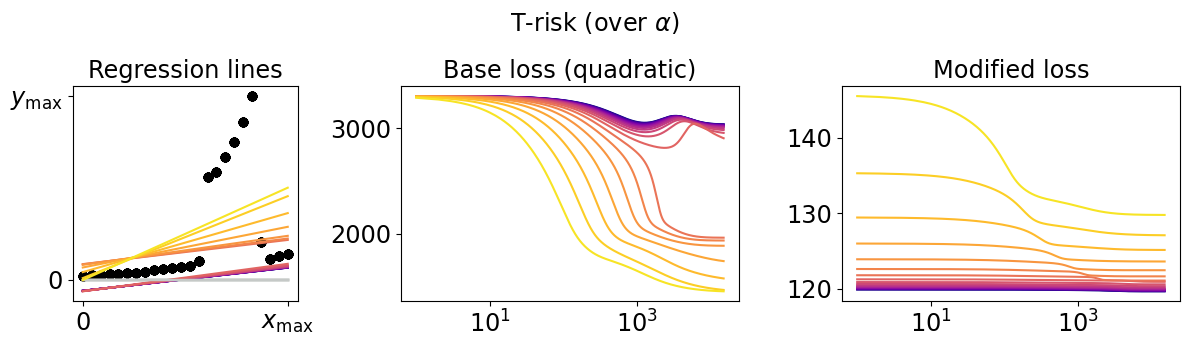

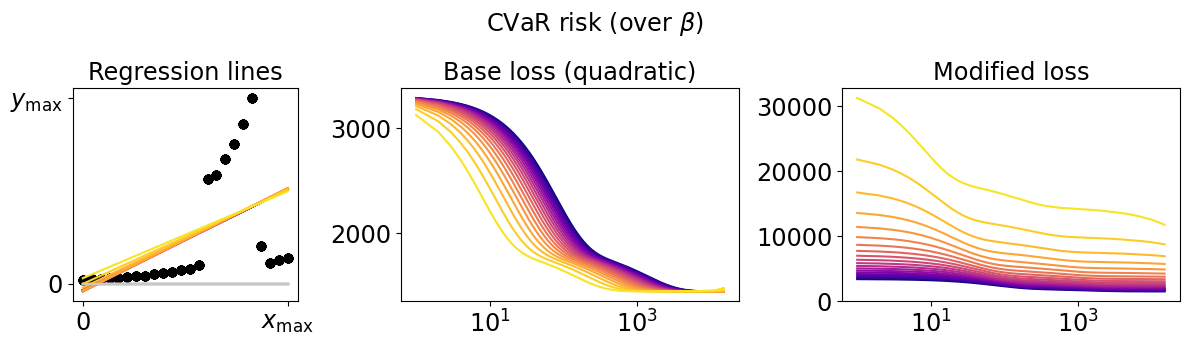

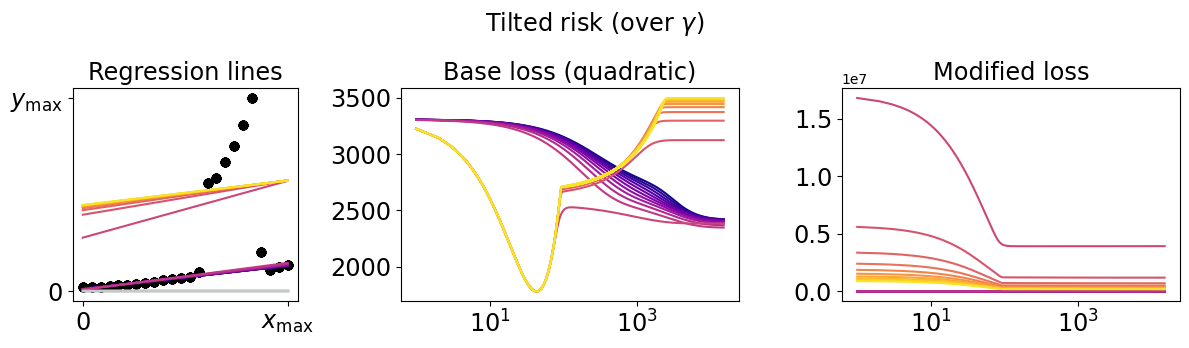

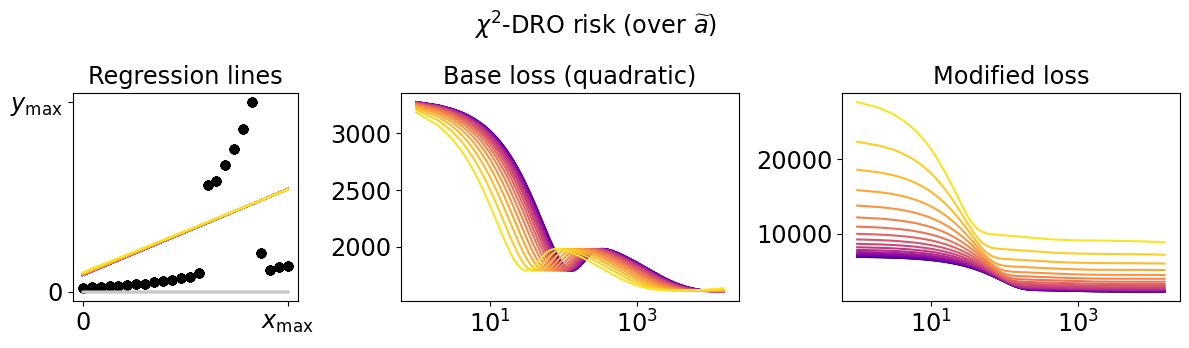

In [16]:
## Similar double loop, this time for visualizing the results.
for risk in todo_risks:
    
    pname, riskparas = todo_riskparas[risk]
    aux_paras = aux_riskparas[risk]
    
    ## Initial figure work.
    fig, (ax_reglines, ax_base, ax_obj) = subplots(1, 3, figsize=(12,3.5),
                                                   gridspec_kw={"width_ratios": [3,4.5,4.5]})
    x_values = np.linspace(0, np.max(X.reshape(-1)), 100)
    y_data = y.reshape(-1)
    regline_init = reglines_init[init_name]
    y_init = x_values*regline_init[0] + regline_init[1]
    
    ## Colour setup.
    cmap = cm.get_cmap("plasma")
    colours = []
    for i in range(len(riskparas)):
        colours += [cmap(i/len(riskparas))]
    
    ## Loop over the individual risks.
    for i, riskpara in enumerate(riskparas):
        
        ## Get relevant values from storage.
        losses_base = storage_base[risk][riskpara]
        losses_obj = storage_obj[risk][riskpara]
        regline = storage_regline[risk][riskpara]
        
        ## Get plotting.
        ax_reglines.scatter(X.reshape(-1), y.reshape(-1), color="xkcd:black")
        y_values = x_values*regline[0] + regline[1]
        ax_reglines.plot(x_values, y_init, color="xkcd:silver")
        ax_reglines.plot(x_values, y_values, color=colours[i])
        ax_base.semilogx(np.arange(1, num_steps+1, 1), losses_base, color=colours[i])
        ax_obj.semilogx(np.arange(1, num_steps+1, 1), losses_obj, color=colours[i])
    
    ## Colorbar.
    #bounds = riskparas
    #cmap = cm.get_cmap("plasma")
    #norm = BoundaryNorm(bounds, cmap.N, extend="both")
    #cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.get_cmap("plasma")),
    #                    ax=ax_obj, label='digit value')
    #cbar.set_ticks([bounds.min(), bounds.max()])
    #cbar.set_ticklabels([str(bounds.min()), str(bounds.max())])
    
    ## Labels and such.
    ax_reglines.set_xticks([0.0, np.max(x_values)])
    ax_reglines.set_xticklabels(["0", r"$x_{\max}$"])
    ax_reglines.set_yticks([0.0, np.max(y_data)])
    ax_reglines.set_yticklabels(["0", r"$y_{\max}$"])
    ax_reglines.set_title("Regression lines", size=my_fontsize)
    ax_base.set_title("Base loss ({})".format(base_name), size=my_fontsize)
    ax_obj.set_title("Modified loss", size=my_fontsize)
    ax_base.tick_params(labelsize=my_fontsize)
    ax_obj.tick_params(labelsize=my_fontsize)
    ax_reglines.tick_params(labelsize=my_fontsize)
    fig.suptitle("{} (over {})".format(risk_names[risk], para_names[pname]), size=my_fontsize)
    fname = path.join(img_dir, "outliers_{}_traj_all_{}.{}".format(dataset, risk, my_ext))
    tight_layout()
    savefig(fname=fname)
    show()

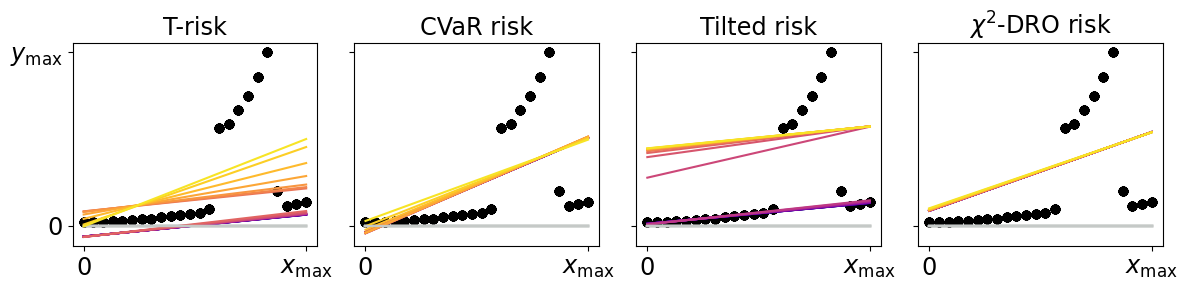

In [17]:
## Just get the regression lines.

fig, axes = subplots(1, len(todo_risks), figsize=(12, 3), sharey=True, sharex=True)

for i, axis in enumerate(axes):
    
    risk = todo_risks[i]
    
    pname, riskparas = todo_riskparas[risk]
    aux_paras = aux_riskparas[risk]
    x_values = np.linspace(0, np.max(X.reshape(-1)), 100)
    y_data = y.reshape(-1)
    regline_init = reglines_init[init_name]
    y_init = x_values*regline_init[0] + regline_init[1]
    
    ## Colour setup.
    cmap = cm.get_cmap("plasma")
    colours = []
    for i in range(len(riskparas)):
        colours += [cmap(i/len(riskparas))]
    
    ## Loop over the individual risks.
    for i, riskpara in enumerate(riskparas):
        
        ## Get relevant values from storage.
        losses_base = storage_base[risk][riskpara]
        losses_obj = storage_obj[risk][riskpara]
        regline = storage_regline[risk][riskpara]
        
        ## Get plotting.
        axis.scatter(X.reshape(-1), y.reshape(-1), color="xkcd:black")
        y_values = x_values*regline[0] + regline[1]
        axis.plot(x_values, y_init, color="xkcd:silver")
        axis.plot(x_values, y_values, color=colours[i])
    
    ## Colorbar.
    #bounds = riskparas
    #cmap = cm.get_cmap("plasma")
    #norm = BoundaryNorm(bounds, cmap.N, extend="both")
    #cbar = fig.colorbar(cm.ScalarMappable(norm=norm,
    #                                      cmap=cm.get_cmap("plasma")),
    #                    ax=axis)
    #cbar.set_ticks([bounds.min(), bounds.max()])
    #cbar.set_ticklabels([str(bounds.min()), str(bounds.max())])
    
    ## Labels and such.
    axis.set_xticks([0.0, np.max(x_values)])
    axis.set_xticklabels(["0", r"$x_{\max}$"])
    axis.set_yticks([0.0, np.max(y_data)])
    axis.set_yticklabels(["0", r"$y_{\max}$"])
    axis.set_title(risk_names[risk], size=my_fontsize)
    axis.tick_params(labelsize=my_fontsize)

## Finally, output the plot.
fname = path.join(img_dir, "outliers_{}_reglines_all_{}.{}".format(dataset, init_name, my_ext))
tight_layout()
savefig(fname=fname)
show()

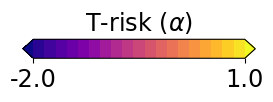

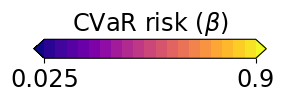

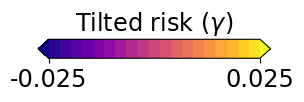

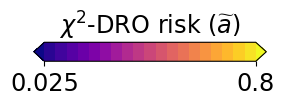

In [18]:
## If desired, we can prepare separate colorbars.
for risk in todo_risks:
    pname, riskparas = todo_riskparas[risk]
    num_risks = len(riskparas)
    fig, ax = subplots(figsize=(3, 0.5))
    fig.subplots_adjust(bottom=0.5)
    bounds = riskparas
    cmap = cm.get_cmap("plasma")
    norm = BoundaryNorm(bounds, cmap.N, extend="both")
    cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
                        cax=ax, orientation="horizontal")
    ax.tick_params(labelsize=my_fontsize)
    cbar.set_ticks([bounds.min(), bounds.max()])
    cbar.set_ticklabels([str(bounds.min()), str(bounds.max())])
    ax.set_title("{} ({})".format(risk_names[risk], para_names[pname]), size=my_fontsize)
    fname = path.join(img_dir, "outliers_{}_traj_all_cbar_{}.{}".format(dataset, risk, my_ext))
    savefig(fname=fname, bbox_inches="tight") # use bbox_inches so text isn't cropped; uncomment to save.
    show()

___